## TFIDF

## Now let’s do our lab

In [12]:
import pandas as pd
file = "IMDB Dataset.csv"
df = pd.read_csv(file)
df.head(20)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Get the stopwords

In [15]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'about', "you're", 'under', 'now', 'those', 'because', 'd', 'ma', 'll', "didn't", 'there', 'a', 'for', 'y', 'itself', 'while', 'that', 'too', "weren't", 'to', 'why', 'how', 'here', 'it', 'some', 'very', 'no', 'of', 'once', "aren't", 'aren', 'shan', 's', "hasn't", 'shouldn', "mightn't", 'are', "you've", 'ours', 'off', 'any', 'mightn', 'her', 'hadn', 'after', 't', 'hers', "don't", 'doing', 'what', 'in', 'so', 'been', "she's", 'being', 'an', 'couldn', "shouldn't", "mustn't", "shan't", 'from', 'they', "wouldn't", 've', 'own', 'whom', 'at', 'have', 'more', "you'd", 'myself', 'their', 'just', "that'll", 'mustn', 'before', 'such', 'them', 'ain', 'has', 'isn', 'is', 'doesn', 'into', 'themselves', 'did', 'nor', 'all', 'theirs', 'out', 'herself', 'not', 'yourselves', 'haven', 'its', 'me', 'where', 'we', 'will', 'should', "it's", 'but', 'below', 'weren', 'were', 'you', 'himself', 'again', 'does', 'until', "won't", 'm', 'our', 'was', 'further', 'won', 'when', 're', 'needn', 'ourselves', "you'll",

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Pre-processing pipeline

In [18]:
import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
pipeline = [str.lower, tokenize, remove_stop]
def prepare(text, pipeline):
    tokens = text
    for fun in pipeline:
        tokens = fun(tokens)
    return tokens
df['tokens'] = df['review'].apply(prepare, pipeline=pipeline)

## Now count the tokens

In [19]:
from collections import Counter
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, 
orient='index', columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'tokens'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
tokens,
br,201951
movie,86767
film,78396
one,52263
like,39229
good,29148
even,24745
would,24428
time,24184


## Now draw the word cloud

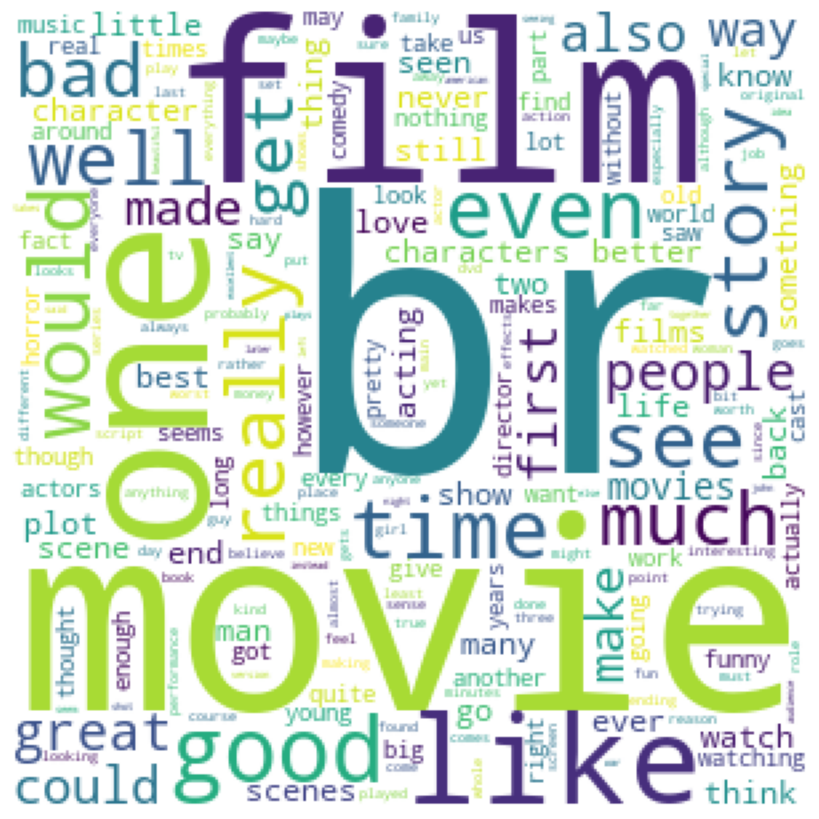

In [20]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
wc = WordCloud(background_color='white', width = 300, height=300, margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Now let’s do the TFIDF and compare

In [21]:
import numpy as np
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
 def update(doc):
   tokens = doc if preprocess is None else preprocess(doc)
   counter.update(set(tokens))
 # count tokens
 counter = Counter()
 df[column].map(update)
 # create data frame and compute idf
 idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
 idf_df = idf_df.query('df >= @min_df')
 idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
 idf_df.index.name = 'token'
 return idf_df
idf_df = compute_idf(df)

## TFIDF = TF * IDF

In [22]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()

,freq,tfidf
tokens,,
br,201951,128801.481176
movie,86767,52064.586124
film,78396,54508.329604
one,52263,35415.619184
like,39229,34712.479339


## Let’s draw the word cloud

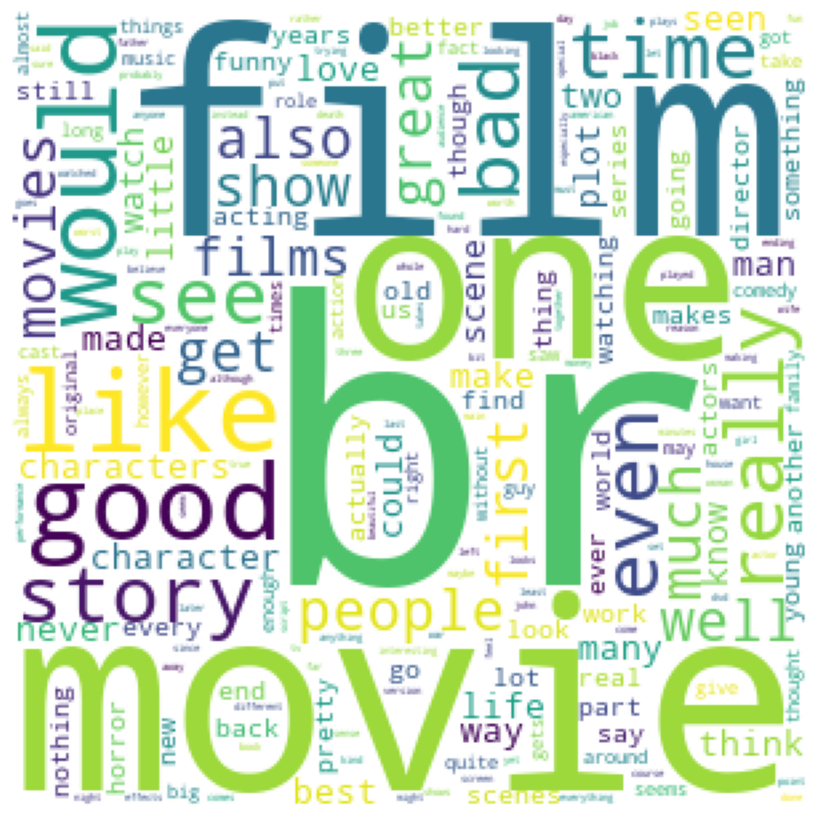

In [23]:
wc = WordCloud(background_color='white', width = 300, height=300,margin=2)
wc.fit_words(freq_df['tfidf'].to_dict() )
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Function to count the keywords

In [24]:
df['num_tokens'] = df['tokens'].map(len)
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

## Function to group by year

In [25]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True)
# if the supplied dataframe has gaps inthe index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by] = df[by] 
# copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)

## Draw

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined the count_keywords_by function and imported necessary libraries

keywords = ['terrorism', 'nuclear', 'war', 'oil', 'syria', 'afghanistan', 'refugees', 'israel', 'peacekeeping',
            'humanitarian', 'climate', 'soviet', 'russia', 'sustainable', 'egypt']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

# Compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

# Apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)

KeyError: 'year'